# 01__motif_model
in this notebook, i find motifs that are significantly associated w/ mean MPRA activity using linear models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys

from itertools import combinations 
from scipy.stats import boxcox
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":8,"axes.titlesize":8,
                       "axes.labelsize":8, 'axes.linewidth':0.5,
                       "legend.fontsize":8, "xtick.labelsize":8,
                       "ytick.labelsize":8, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

In [4]:
QUANT_ALPHA = 0.05

## functions

In [5]:
def calculate_gc(row):
    cs = row["index"].count("C")
    gs = row["index"].count("G")
    gc = (cs+gs)/len(row["index"])
    return gc

In [6]:
def calculate_cpg(row):
    cpgs = row["index"].count("CG")
    cpg = cpgs/len(row["index"])
    return cpg

In [7]:
def lrtest(llmin, llmax):
    lr = 2 * (llmax - llmin)
    p = stats.chisqprob(lr, 1) # llmax has 1 dof more than llmin
    return lr, p

In [8]:
def activ_or_repress(row):
    if row.beta > 0:
        return "activating"
    elif row.beta < 0:
        return "repressing"

## variables

In [9]:
data_f = "../../data/02_activs/alpha_per_elem.quantification.CM.5.txt"
data_vsmc_f = "../../data/02_activs/alpha_per_elem.quantification.VSMC.4.txt"

In [10]:
index_f = "../../data/design/Hypertension__pooled.index.txt"

In [11]:
motif_dir = "../../data/03_fimo/FIMO_results/"
motifs_f = "%s/hum_tf/fimo.txt" % motif_dir

In [12]:
motif_info_dir = "../../data/03_fimo/Kaia_FIMO/"
motif_map_f = "%s/curated_motif_map.txt" % motif_info_dir
motif_info_f = "%s/motif_info.txt" % motif_info_dir

In [13]:
HEK_tf_f = "../RNASeq/HEK_all.counts.voom.txt"
VSMC_tf_f = "../RNASeq/VSMC_all.counts.voom.txt"
CM_tf_1f = "../../../../../../Data/Hypertension/CM/RNASeq/GSM3262978_RZY637_RNA_D80_1-chrM.rpkm.gz"
CM_tf_2f = "../../../../../../Data/Hypertension/CM/RNASeq/GSM3262979_RZY643_RNA_D80_2-chrM.rpkm.gz"

## 1. import data 

In [14]:
data = pd.read_table(data_vsmc_f).reset_index()
data.head()

,index,VSMC,VSMC_pval,VSMC_padj
0,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,0.267451,0.511170,0.90414
1,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,0.261744,0.524173,0.90414
2,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,0.228496,0.598982,0.90414
3,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,0.245130,0.561830,0.90414
4,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,0.143115,0.770000,0.90414


In [15]:
index = pd.read_table(index_f, sep="\t")
index.head()

,element,tile_type,tile_id,name,parse_details,chrom,start,end,strand,actual_start,...,RE_1,RE_2,RE_3,REs_mutated,unique_name,snp,barcode,oligo,oligo_len,pool_num
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTGCTTGATAC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
1,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.2,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CTCGGCGAACA,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
2,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.3,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,CATGTTCGAGT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
3,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.4,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATCGTAAACTC,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1
4,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,1.1.0.0.0.0.5,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,106410709,106410844,+,106410709,...,0,1,0,none,chr7:106410709:106410844__rs12705390__7:106410...,none,ATAGGTTCGCT,ACTGGCCGCTTCACTGACTAATGGCTGGAAAATGTTTCTACTTCTA...,191,1


In [16]:
index['dupe_info'] = index['tile_id'].str.split('.',expand=True)[0]
index_elem = index[["element", "tile_type", "name",'unique_name', "chrom", "strand", "actual_start", 
                    "actual_end", "dupe_info"]]
index_elem = index_elem.drop_duplicates()

In [17]:
motifs = pd.read_table(motifs_f, sep="\t")
motifs.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,ZNF496,ZNF496,chr3:48020950:48021085__rs28637561__3:48021018...,32,61,+,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
1,ZNF496,ZNF496,chr3:48020950:48021085__rs28637561__3:48021018...,32,61,+,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
2,ZNF496,ZNF496,chr1:9440193:9440328__rs28742181__1:9440261:C:...,16,45,-,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
3,ZNF496,ZNF496,chr1:9440193:9440328__rs28742181__1:9440261:C:...,16,45,-,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT
4,ZNF496,ZNF496,chr1:9440130:9440265__rs28669777__1:9440198:C:...,79,108,-,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT


In [18]:
motif_map = pd.read_table(motif_map_f, sep="\t")
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [19]:
motif_info = pd.read_table(motif_info_f, sep="\t")
motif_info.head()

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
0,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_HT-SELEX,HT-SELEX,Yin2017,M08490_1.94d,True
1,ENSG00000267281,AC023509.3,"Inferred - ATF7 (100% AA Identity, Homo sapiens)",ATF7_eDBD_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M08491_1.94d,NaN
2,ENSG00000267281,AC023509.3,"Inferred - Atf7 (98% AA Identity, Mus musculus)",3T3L1-Atf7_GSE56872,Misc,HOMER,M06975_1.94d,NaN
3,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_HT-SELEX,HT-SELEX,Yin2017,M09315_1.94d,True
4,ENSG00000264668,AC138696.1,"Inferred - ZFP41 (100% AA Identity, Homo sapiens)",ZFP41_FL_Methyl-HT-SELEX,Methyl-HT-SELEX,Yin2017,M09316_1.94d,NaN


In [20]:
HEK_tf = pd.read_table(HEK_tf_f)
VSMC_tf = pd.read_table(VSMC_tf_f)
VSMC_tf.head()

,gene_id,rep1,rep2,VSMC
0,ENSG00000223972.5,0,1,1
1,ENSG00000227232.5,133,151,284
2,ENSG00000278267.1,23,44,67
3,ENSG00000243485.5,0,0,0
4,ENSG00000284332.1,0,0,0


In [22]:
CM_tf_1 = pd.read_table(CM_tf_1f)
CM_tf_2 = pd.read_table(CM_tf_2f)
CM_tf_2.head()

,Geneid,Chr,Start,End,Strand,Length,bam.RZY643_RNA_D80_2.nodup.bam
0,DDX11L1,chr1;chr1;chr1;chr1,11869;12595;12975;13221,12227;12721;13052;14412,+;+;+;+,1756,0.011473
1,WASH7P,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14363;14970;15796;16607;16854;17233;17498;1760...,14829;15038;15947;16765;17055;17368;17504;1774...,-;-;-;-;-;-;-;-;-;-;-;-;-,2073,8.435567
2,MIR1302-11,chr1;chr1;chr1,29554;30267;30976,30039;30667;31109,+;+;+,1021,0.019732
3,FAM138A,chr1;chr1;chr1,34554;35245;35721,35174;35481;36081,-;-;-,1219,0.000000
4,OR4G4P,chr1;chr1,52473;54830,53312;54936,+;+,947,0.000000


## 2. calculate GC and CpG content per element

In [103]:
data["gc_content"] = data.apply(calculate_gc, axis=1)
data.sample(5)

,index,VSMC,VSMC_pval,VSMC_padj,gc_content
532,AACTCTTTGGTCCATTTTTTTAATCAGGTTGTTTGCGTTCTTATCG...,0.310971,0.412620,0.904140,0.340741
8121,TGAAAATAGTGGCATCAACTAGCTGATAATTTGAAGACTTTTCTAA...,0.235010,0.584521,0.904140,0.311111
519,AACTATATCGGTTGACTTTACCTTATCTGAAATGCTTGGGATGAGA...,0.321229,0.389948,0.904140,0.333333
3029,CACACGCTGGATGGCGCAACCCGCTGCTAAGGTCTCTCCACCCGGA...,0.340140,0.349167,0.904140,0.607407
2378,ATCAAAAACTAGAAGTCACCTGCATGGCTATCACTGCAGAATTTGG...,0.602426,0.029573,0.373633,0.422222


In [104]:
data["cpg_content"] = data.apply(calculate_cpg, axis=1)
data.sample(5)

,index,VSMC,VSMC_pval,VSMC_padj,gc_content,cpg_content
797,AATATTCAGTTGTTCCAGTACATTTGTTAAAAACACTAGCCTCTCC...,116.324974,0.000000,0.00000,0.511111,0.014815
5541,GATGTCTTGAGACACAGAGGTAAGGAGAAGGCATTGTGCAGAAAGA...,0.119969,0.808171,0.90414,0.437037,0.000000
7122,TAATACTTTTGGTGCCAAGCACTTGGCTAAATAGTTTACATAATTT...,0.365627,0.296918,0.90414,0.318519,0.000000
7780,TCCAAGCCAGTTGCCATGCTAAACATTTCCCATGTATGAGCAATCT...,0.191742,0.677543,0.90414,0.333333,0.000000
6288,GGCTGAGGCAGGTGGATCACATGAGGCCAGGAGTTAGAGACCAGCC...,0.372194,0.284058,0.90414,0.503704,0.014815


In [106]:
data["VSMC_log"] = np.log10(data["VSMC"]+1)
data.sample(5)

,index,VSMC,VSMC_pval,VSMC_padj,gc_content,cpg_content,VSMC_log
3505,CATTTTACAGATGGGGAGACTGGGTTGGGGTTGGGGTTGGGGATGG...,0.354293,0.319717,0.90414,0.548148,0.022222,0.131713
278,AAAGCTGAGTTATTTCATAATATAGTAAATACAGTCATGGTAAAAT...,0.362561,0.303012,0.90414,0.251852,0.007407,0.134356
2298,ATAGACATATGCACTTAGCATACTGACTAAAAGCACAGGGCTGCAG...,0.252104,0.546073,0.90414,0.451852,0.007407,0.097640
9241,TTGAGTGCTAACTACATCTTTAGGATTTCTCTCTCTCTCTCTTTCT...,0.149234,0.759242,0.90414,0.407407,0.007407,0.060408
1570,AGACTGAGAGAGGATTACCTGAACCCAGGAGTTTGAGGCTGTAGTG...,0.301647,0.433487,0.90414,0.437037,0.000000,0.114493


In [107]:
data["avg_activ"] = data[["VSMC"]].mean(axis=1)
data["avg_activ_log"] = np.log10(data["avg_activ"]+1)

In [108]:
data["VSMC_box"] = boxcox(data["VSMC"])[0]
data["avg_activ_box"] = boxcox(data["avg_activ"])[0]
data.sample(5)

,index,VSMC,VSMC_pval,VSMC_padj,gc_content,cpg_content,VSMC_log,avg_activ,avg_activ_log,VSMC_box,avg_activ_box
2782,ATTTATTTTAATGTGTTTTAGAAAAAAAAAACTAATAATGCATCCA...,0.131328,7.899471e-01,9.041396e-01,0.281481,0.014815,0.053588,0.131328,0.053588,-0.118034,-0.118034
1607,AGAGATGGGGTTTCACTGTGTTAGCCAGGATGGTCTCGATCTCCTG...,1.305642,1.736826e-09,6.687469e-08,0.562963,0.037037,0.362792,1.305642,0.362792,1.012501,1.012501
6982,TAAAAAAATATCAGCCAGGTGTGGTGACGCACACCTGTAGTCTTAG...,0.211704,6.355979e-01,9.041396e-01,0.488889,0.014815,0.083396,0.211704,0.083396,-0.118034,-0.118034
1,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,0.261744,5.241730e-01,9.041396e-01,0.451852,0.014815,0.100971,0.261744,0.100971,-0.118033,-0.118033
9678,TTTTTTCCACTATCAGTTTCCTCCTGCCAATACTTTCTTTTCTATC...,0.080617,8.634947e-01,9.114489e-01,0.340741,0.000000,0.033672,0.080617,0.033672,-0.118034,-0.118034


In [109]:
data["short_elem"] = data["index"].str.split("__", expand=True)[0]
data.sample(5)

,index,VSMC,VSMC_pval,VSMC_padj,gc_content,cpg_content,VSMC_log,avg_activ,avg_activ_log,VSMC_box,avg_activ_box,short_elem
6994,TAAAAATACAACATTAGCCGGGTGTGGTGGCACATGCCTGTAATCC...,0.389132,0.252174,0.904140,0.511111,0.029630,0.142743,0.389132,0.142743,-0.117994,-0.117994,TAAAAATACAACATTAGCCGGGTGTGGTGGCACATGCCTGTAATCC...
2048,AGTAAAGTAAGCCACACAAATTTTTTGGTTTCCTAGTGTATATGTA...,0.702501,0.006961,0.116643,0.288889,0.007407,0.231087,0.702501,0.231087,-0.112108,-0.112108,AGTAAAGTAAGCCACACAAATTTTTTGGTTTCCTAGTGTATATGTA...
177,AAAATGTTAAATATGTCAGACACTTGACTAACATGTACAAATTCCT...,0.340774,0.347825,0.904140,0.407407,0.007407,0.127356,0.340774,0.127356,-0.118021,-0.118021,AAAATGTTAAATATGTCAGACACTTGACTAACATGTACAAATTCCT...
7449,TATCAGGCGCCGTGGAGTTACCAGCTAGAGAGACTTTTCTCCTGGT...,0.410480,0.214846,0.904140,0.503704,0.014815,0.149367,0.410480,0.149367,-0.117972,-0.117972,TATCAGGCGCCGTGGAGTTACCAGCTAGAGAGACTTTTCTCCTGGT...
8130,TGAAAGTGAATGGGCCTTCATGGCTGTCTCAACTCAAAGAGTTCTG...,0.262008,0.523571,0.904140,0.481481,0.000000,0.101062,0.262008,0.101062,-0.118033,-0.118033,TGAAAGTGAATGGGCCTTCATGGCTGTCTCAACTCAAAGAGTTCTG...


## 3. build reduced model (CG + CpG content)

In [110]:
scaled_features = StandardScaler().fit_transform(data[["avg_activ_box", "gc_content", "cpg_content"]])
data_norm = pd.DataFrame(scaled_features, index=data.index, columns=["avg_activ_box", "gc_content", "cpg_content"])
data_norm["index"] = data['index']
data_norm["VSMC_padj"] = data["VSMC_padj"]
data_norm["short_elem"] = data["short_elem"]
data_norm.head()

,avg_activ_box,gc_content,cpg_content,index,VSMC_padj,short_elem
0,-0.010725,0.109517,-0.389273,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,0.90414,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...
1,-0.010725,0.179827,-0.008471,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...,0.90414,AAAGGCTGTGATTGTACGTGCAACTGTCATCTTGCTGGGATTGTGT...
2,-0.010725,-0.593581,-0.008471,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,0.90414,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...
3,-0.010725,-0.593581,-0.389273,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...,0.90414,AACAGTGAAAATGATAATTCAAACTAATACTGTTTACAGGGAGTTA...
4,-0.010725,-0.242032,0.372330,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...,0.90414,ACAGACAATAACTCAGTGCCTGGCAAACAGTGAGCACTATGCAAAC...


In [112]:
data_filt = data_norm[((data_norm["VSMC_padj"] < QUANT_ALPHA))]
len(data_filt)

493

In [116]:
avg_mod = smf.ols(formula='avg_activ_box ~ gc_content + cpg_content', 
                   data=data_norm).fit()

In [117]:
avg_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_activ_box   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3862
Date:                Thu, 09 Sep 2021   Prob (F-statistic):              0.680
Time:                        14:26:36   Log-Likelihood:                -13768.
No. Observations:                9703   AIC:                         2.754e+04
Df Residuals:                    9700   BIC:                         2.756e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -1.156e-06      0.010     -0.000      1.000      -0.020       0.020
gc_content      0.0048      0.013      0.373      0.709      -0.020       0.030
cpg_content     0.0052      0.013      0.405      0.686      -0.020       0.030
==============================================================================
Omnibus:                    38363.617   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      37531579326.671
Skew:                          98.011   Prob(JB):                         0.00
Kurtosis:                    9635.990   Cond. No.                         2.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Normal QQ: average CM model')

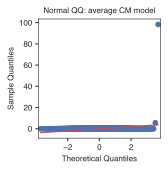

In [118]:
res = avg_mod.resid

fig, ax = plt.subplots(figsize=(2.2, 2.2), ncols=1, nrows=1)
sm.qqplot(res, line='s', ax=ax)
ax.set_title("Normal QQ: average CM model")
# fig.savefig("avg_activ_qq.pdf", dpi="figure", bbox_inches="tight")

In [119]:
res[res>80]

1659    98.329117
dtype: float64

In [120]:
reduced_llf = avg_mod.llf
reduced_llf

-13767.574321886907

In [121]:
reduced_rsq = avg_mod.rsquared
reduced_rsq

7.961463910499678e-05

## 4. add individual motifs to the model

In [21]:
len(motifs)

1893432

In [22]:
# only analyze the "best" motifs as determined by lambert et al
best_motifs = motif_info[~pd.isnull(motif_info["Best Motif(s)? (Figure 2A)"])]
len(best_motifs)

1496

In [18]:
best_motifs[best_motifs['HGNC symbol']=='RARA']

,Ensembl ID,HGNC symbol,Motif evidence,Motif ID,Motif type,Motif source,CIS-BP ID,Best Motif(s)? (Figure 2A)
21698,ENSG00000131759,RARA,Direct,RARA_eDBD_HT-SELEX_3,HT-SELEX,Yin2017,M10176_1.94d,True


In [24]:
best_motifs['HGNC symbol'].to_csv('/home/winona/marenostrum/Projects/Breast/ANALYSIS/Hypertension/analysis/02_TF_analysis/tested_TFs.txt', sep='\n', header=False, index=False)

In [31]:
best_motifs["short_id"] = best_motifs["CIS-BP ID"].str.split(".", expand=True)[0]
mapped_best_motifs = motifs[motifs["# motif_id"].isin(best_motifs["short_id"])]
len(mapped_best_motifs)

587735

In [32]:
uniq_motifs = list(best_motifs["short_id"].unique())
print(len(uniq_motifs))

1402


In [34]:
index['sequence name'] = index['unique_name']+'_'+index['tile_type']
index.sample(5)

,element,tile_type,tile_id,name,parse_details,chrom,start,end,strand,actual_start,...,RE_3,REs_mutated,unique_name,snp,barcode,oligo,oligo_len,pool_num,dupe_info,sequence name
101846,TAGAGTCCTTGCTGGCATCCTGGAAGGCCTGCCCCAGCCGCAAGCC...,WILDTYPE_BUT_HAS_SNP,2048.1.0.0.0.0.22,chr5:173358269:173358404__rs7705507__5:1733583...,chr5:173358269:173358404__rs7705507__5:1733583...,chr5,173358269,173358404,+,173358269,...,0,none,chr5:173358269:173358404__rs7705507__5:1733583...,none,TTCGTTTCGCA,ACTGGCCGCTTCACTGTAGAGTCCTTGCTGGCATCCTGGAAGGCCT...,191,1,2048,chr5:173358269:173358404__rs7705507__5:1733583...
193048,TACTCAGGAGACTGAGGCAGGAGAATTGCTTGAACCAGGACCCAGG...,WILDTYPE_BUT_HAS_SNP,3877.1.0.0.0.0.24,chr3:41844544:41844679__rs111520733__3:4184461...,chr3:41844544:41844679__rs111520733__3:4184461...,chr3,41844544,41844679,+,41844544,...,0,none,chr3:41844544:41844679__rs111520733__3:4184461...,none,TGTCCGCGTCA,ACTGGCCGCTTCACTGTACTCAGGAGACTGAGGCAGGAGAATTGCT...,191,2,3877,chr3:41844544:41844679__rs111520733__3:4184461...
101680,AGTGAGACCCTGTCTCAAAAATTAAAATAATAATAATAATAGTCCT...,WILDTYPE_BUT_HAS_SNP,2045.1.0.0.0.0.6,chr5:173356684:173356819__rs72812818__5:173356...,chr5:173356684:173356819__rs72812818__5:173356...,chr5,173356684,173356819,+,173356684,...,0,none,chr5:173356684:173356819__rs72812818__5:173356...,none,AGAATGGCTCG,ACTGGCCGCTTCACTGAGTGAGACCCTGTCTCAAAAATTAAAATAA...,191,1,2045,chr5:173356684:173356819__rs72812818__5:173356...
148591,AGCTACAAAGGGGGGGCAAGAGCTGAAAAACTATCAAGTACTGTGT...,WILDTYPE_SNP_INDIV,2984.1.0.68.0.0.17,chr1:56594043:56594178__rs1331859__1:56594111:C:A,chr1:56594043:56594178__rs1331859__1:56594111:...,chr1,56594043,56594178,+,56594043,...,0,none,chr1:56594043:56594178__rs1331859__1:56594111:...,rs1331859,GGACGCGATTC,ACTGGCCGCTTCACTGAGCTACAAAGGGGGGGCAAGAGCTGAAAAA...,191,2,2984,chr1:56594043:56594178__rs1331859__1:56594111:...
85741,TTAATTAAAATTATTTTTAGTGAATGACACTCGTCTATAAGTGAAA...,WILDTYPE_SNP_INDIV,1723.1.0.68.0.0.17,chr1:217723859:217723994__rs72747609__1:217723...,chr1:217723859:217723994__rs72747609__1:217723...,chr1,217723859,217723994,+,217723859,...,0,none,chr1:217723859:217723994__rs72747609__1:217723...,rs72747609,CAGTAACAGAT,ACTGGCCGCTTCACTGTTAATTAAAATTATTTTTAGTGAATGACAC...,191,1,1723,chr1:217723859:217723994__rs72747609__1:217723...


In [129]:
motif_results = {}

for i, motif_id in enumerate(uniq_motifs):
    tmp = data_norm.copy()

    elem_ids_w_motif = list(mapped_best_motifs[mapped_best_motifs["# motif_id"] == motif_id]["sequence_name"].unique())
    elems_w_motif = list(index[index["sequence name"].isin(elem_ids_w_motif)]["element"])
    
    tmp["has_motif"] = tmp["short_elem"].isin(elems_w_motif)
    tmp["has_motif"] = tmp["has_motif"].astype(int)
    
    # build model with motif included
    motif_mod = smf.ols(formula='avg_activ_box ~ gc_content + cpg_content + has_motif', 
                        data=tmp).fit()
    
    # perform likelihood ratio test
    motif_llf = motif_mod.llf
    lr, p = lrtest(reduced_llf, motif_llf)
    
    # calculate additional variance explained
    rsq = motif_mod.rsquared - reduced_rsq
    
    # record beta
    beta = list(motif_mod.params)[-1]
    
    print("(#%s) %s: n w/ motif: %s ... p: %s, rsquared: %s" % (i+1, motif_id, len(elems_w_motif), p, rsq))
    motif_results[motif_id] = {"lr_test": lr, "pval": p, "rsq": rsq, "beta": beta}

(#1) M08490_1: n w/ motif: 2020 ... p: 0.9426650709017165, rsquared: 5.330479293519375e-07
(#2) M09315_1: n w/ motif: 4335 ... p: 0.8339583556921564, rsquared: 4.528508949164234e-06
(#3) M03663_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#4) M06440_1: n w/ motif: 5690 ... p: 0.8961640451948563, rsquared: 1.755243270062934e-06
(#5) M08464_1: n w/ motif: 6280 ... p: 0.9502896469138586, rsquared: 4.0053030536668643e-07
(#6) M05586_1: n w/ motif: 6230 ... p: 0.9464304050710924, rsquared: 4.6523163266254386e-07
(#7) M05560_1: n w/ motif: 4675 ... p: 0.9265474890075559, rsquared: 8.758344370862758e-07
(#8) M05562_1: n w/ motif: 4865 ... p: 0.9433917420666228, rsquared: 5.195991185091842e-07
(#9) M08468_1: n w/ motif: 2070 ... p: 0.9382631201559241, rsquared: 6.18210791225593e-07
(#10) M01298_1: n w/ motif: 4900 ... p: 0.9209182026948279, rsquared: 1.0156824968854394e-06
(#11) M05563_1: n w/ motif: 1830 ... p: 0.9150663365779107, rsquared: 1.1721523940355638e-06
(#12) M05564_1: n w/ motif: 23

(#93) M03668_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#94) M05595_1: n w/ motif: 1510 ... p: 0.8617150930824603, rsquared: 3.1268843585507966e-06
(#95) M00846_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#96) M02158_1: n w/ motif: 6825 ... p: 0.8725605458169094, rsquared: 2.6515814190997133e-06
(#97) M05596_1: n w/ motif: 2560 ... p: 0.8908457960071463, rsquared: 1.940808752709522e-06
(#98) M08534_1: n w/ motif: 3255 ... p: 0.8564316226477034, rsquared: 3.373060696199026e-06
(#99) M05597_1: n w/ motif: 16690 ... p: 0.8806115720307398, rsquared: 2.3246841889257297e-06
(#100) M10066_1: n w/ motif: 680 ... p: 0.9254335813340271, rsquared: 9.02678197856055e-07
(#101) M10072_1: n w/ motif: 1745 ... p: 0.9045435782887683, rsquared: 1.482071704028698e-06
(#102) M05601_1: n w/ motif: 2035 ... p: 0.8801368123244789, rsquared: 2.343350650746423e-06
(#103) M00402_1: n w/ motif: 2405 ... p: 0.8796117829881576, rsquared: 2.3640825023152345e-06
(#104) M10091_1: n w/ motif: 2795 ... p: 0.8622959894

(#188) M05674_1: n w/ motif: 2235 ... p: 0.8992479847241909, rsquared: 1.6519791387059612e-06
(#189) M08629_1: n w/ motif: 6170 ... p: 0.8074502926978048, rsquared: 6.121084724752812e-06
(#190) M02002_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#191) M08633_1: n w/ motif: 7260 ... p: 0.8174068586078244, rsquared: 5.493340150874992e-06
(#192) M05685_1: n w/ motif: 6150 ... p: 0.8534728338143978, rsquared: 3.5151311296166554e-06
(#193) M08637_1: n w/ motif: 6315 ... p: 0.8206705748562917, rsquared: 5.2953482779782846e-06
(#194) M08639_1: n w/ motif: 7155 ... p: 0.8127387228924932, rsquared: 5.783192978170426e-06
(#195) M05689_1: n w/ motif: 2630 ... p: 0.9189168718100301, rsquared: 1.0679211066566552e-06
(#196) M05692_1: n w/ motif: 1750 ... p: 0.9016740700089161, rsquared: 1.572977352704008e-06
(#197) M08647_1: n w/ motif: 1610 ... p: 0.9074209131893571, rsquared: 1.3936726279695222e-06
(#198) M05695_1: n w/ motif: 1435 ... p: 0.900226560182741, rsquared: 1.6198767485153809e-06
(#199) M

(#281) M06396_1: n w/ motif: 3635 ... p: 0.9337862672201535, rsquared: 7.113348007292686e-07
(#282) M08709_1: n w/ motif: 1880 ... p: 0.9235165617272302, rsquared: 9.498331924318038e-07
(#283) M05752_1: n w/ motif: 4405 ... p: 0.913643124317415, rsquared: 1.2119200706317557e-06
(#284) M05753_1: n w/ motif: 4910 ... p: 0.9180977837798074, rsquared: 1.089682581945084e-06
(#285) M08711_1: n w/ motif: 2650 ... p: 0.9325154659100601, rsquared: 7.389672567192918e-07
(#286) M09589_1: n w/ motif: 3700 ... p: 0.9142551220183129, rsquared: 1.1947372691167857e-06
(#287) M08713_1: n w/ motif: 2055 ... p: 0.934767454311016, rsquared: 6.903624107934547e-07
(#288) M05755_1: n w/ motif: 2185 ... p: 0.9264317709684214, rsquared: 8.786040727182254e-07
(#289) M05758_1: n w/ motif: 2905 ... p: 0.9218702965880039, rsquared: 9.91295304397788e-07
(#290) M05761_1: n w/ motif: 3735 ... p: 0.8711576285364955, rsquared: 2.7107999475139977e-06
(#291) M05762_1: n w/ motif: 3245 ... p: 0.8735264563632829, rsquared:

(#374) M01466_1: n w/ motif: 3355 ... p: 0.9197070412689545, rsquared: 1.047138075471743e-06
(#375) M08784_1: n w/ motif: 3330 ... p: 0.9252137516104946, rsquared: 9.080241062386918e-07
(#376) M08787_1: n w/ motif: 2445 ... p: 0.9479624245260623, rsquared: 4.389648524671941e-07
(#377) M08786_1: n w/ motif: 2945 ... p: 0.9423136205325446, rsquared: 5.396143413216592e-07
(#378) M08788_1: n w/ motif: 2890 ... p: 0.9407203829851088, rsquared: 5.698888876359831e-07
(#379) M08789_1: n w/ motif: 2475 ... p: 0.9511728277083381, rsquared: 3.8640702004766325e-07
(#380) M05806_1: n w/ motif: 3760 ... p: 0.9392054099145428, rsquared: 5.994469615133724e-07
(#381) M08790_1: n w/ motif: 2610 ... p: 0.9567784896090884, rsquared: 3.0269427875317945e-07
(#382) M01268_1: n w/ motif: 6525 ... p: 0.9122994641902973, rsquared: 1.2500809635218602e-06
(#383) M05816_1: n w/ motif: 2885 ... p: 0.9340790158502165, rsquared: 7.050443735501233e-07
(#384) M08792_1: n w/ motif: 1860 ... p: 0.9568206512844578, rsquar

(#465) M08868_1: n w/ motif: 15065 ... p: 0.5992618385012677, rsquared: 2.8453544493767247e-05
(#466) M05867_1: n w/ motif: 9745 ... p: 0.6623606229938026, rsquared: 1.9648734894128772e-05
(#467) M08872_1: n w/ motif: 14615 ... p: 0.5961505999953907, rsquared: 2.894099370565062e-05
(#468) M08876_1: n w/ motif: 17860 ... p: 0.00018938217901819885, rsquared: 0.0014348651804972912
(#469) M08874_1: n w/ motif: 17080 ... p: 0.00011311894751520712, rsquared: 0.0015347252482914575
(#470) M05868_1: n w/ motif: 15595 ... p: 5.1641874410762204e-05, rsquared: 0.0016872855054999025
(#471) M08878_1: n w/ motif: 16395 ... p: 9.59576215435975e-05, rsquared: 0.0015666791578079486
(#472) M08880_1: n w/ motif: 12910 ... p: 0.6758920800077374, rsquared: 1.8012104272879803e-05
(#473) M08881_1: n w/ motif: 17120 ... p: 0.5664189893011025, rsquared: 3.387400034937649e-05
(#474) M08883_1: n w/ motif: 13540 ... p: 0.6179696819221681, rsquared: 2.563212579320684e-05
(#475) M08884_1: n w/ motif: 18645 ... p: 0.

(#558) M09836_1: n w/ motif: 4930 ... p: 0.835767159682825, rsquared: 4.428964301528282e-06
(#559) M09843_1: n w/ motif: 3805 ... p: 0.8839853576467973, rsquared: 2.19423133618335e-06
(#560) M01967_1: n w/ motif: 3110 ... p: 0.8780504076673511, rsquared: 2.426288672752186e-06
(#561) M00842_1: n w/ motif: 6120 ... p: 0.909826495805906, rsquared: 1.321880574223222e-06
(#562) M06657_1: n w/ motif: 15810 ... p: 0.7204245765096381, rsquared: 1.3199548716369414e-05
(#563) M01755_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#564) M08942_1: n w/ motif: 3450 ... p: 0.8813730225165084, rsquared: 2.2949050578757735e-06
(#565) M05927_1: n w/ motif: 3065 ... p: 0.9218532170265038, rsquared: 9.91730149890735e-07
(#566) M08949_1: n w/ motif: 2215 ... p: 0.9423024830794087, rsquared: 5.39823090894842e-07
(#567) M08947_1: n w/ motif: 2510 ... p: 0.9431559176028462, rsquared: 5.239446926319502e-07
(#568) M08951_1: n w/ motif: 2345 ... p: 0.9421292138943435, rsquared: 5.430759127955653e-07
(#569) M08953_1

(#649) M05963_1: n w/ motif: 2260 ... p: 0.8166116502801012, rsquared: 5.542161011784508e-06
(#650) M09011_1: n w/ motif: 3935 ... p: 0.8856400968123809, rsquared: 2.1316539950966273e-06
(#651) M05965_1: n w/ motif: 2295 ... p: 0.9447540974700273, rsquared: 4.948507500435184e-07
(#652) M09896_1: n w/ motif: 3545 ... p: 0.9380093378640852, rsquared: 6.233140836808815e-07
(#653) M09899_1: n w/ motif: 3525 ... p: 0.93268667915513, rsquared: 7.352134661076093e-07
(#654) M07569_1: n w/ motif: 2315 ... p: 0.9490850909974657, rsquared: 4.2020309476420437e-07
(#655) M09903_1: n w/ motif: 1170 ... p: 0.9384984080517519, rsquared: 6.13498251200717e-07
(#656) M05972_1: n w/ motif: 9790 ... p: 0.9080359768492683, rsquared: 1.3751336742640063e-06
(#657) M09023_1: n w/ motif: 445 ... p: 0.9389690390130743, rsquared: 6.04126488279455e-07
(#658) M09025_1: n w/ motif: 3870 ... p: 0.8725927954049062, rsquared: 2.650228020040224e-06
(#659) M09027_1: n w/ motif: 4010 ... p: 0.8729499625043484, rsquared: 2

(#741) M10176_1: n w/ motif: 14985 ... p: 5.545599872045894e-05, rsquared: 0.0016733932472271507
(#742) M10181_1: n w/ motif: 15820 ... p: 9.48749321192593e-05, rsquared: 0.0015688840754076727
(#743) M01985_1: n w/ motif: 4840 ... p: 0.8419068723301242, rsquared: 4.099663216239335e-06
(#744) M06046_1: n w/ motif: 4195 ... p: 0.9267673333516275, rsquared: 8.705847499568264e-07
(#745) M09095_1: n w/ motif: 4105 ... p: 0.9404961640899607, rsquared: 5.742161595101436e-07
(#746) M06047_1: n w/ motif: 3820 ... p: 0.9317484425668041, rsquared: 7.559021525382903e-07
(#747) RBAK: n w/ motif: 17950 ... p: 0.6849889875227324, rsquared: 1.6958605217332057e-05
(#748) M00862_1: n w/ motif: 9060 ... p: 0.8109971485246823, rsquared: 5.893346642582564e-06
(#749) M07039_1: n w/ motif: 10550 ... p: 0.7993928858076572, rsquared: 6.655485409567952e-06
(#750) M02665_1: n w/ motif: 5710 ... p: 0.8247794479566359, rsquared: 5.051511077436288e-06
(#751) M05337_1: n w/ motif: 8110 ... p: 0.7984434627747659, rsq

(#834) M07528_1: n w/ motif: 11135 ... p: 0.6739615910214986, rsquared: 1.824046853871053e-05
(#835) M04506_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#836) M06131_1: n w/ motif: 16410 ... p: 0.00010175821437106735, rsquared: 0.001555276695994423
(#837) M09183_1: n w/ motif: 14200 ... p: 0.6013474471798425, rsquared: 2.812973791710416e-05
(#838) M09185_1: n w/ motif: 16825 ... p: 0.00011398567982156304, rsquared: 0.0015332436609938327
(#839) M06135_1: n w/ motif: 1585 ... p: 0.901930796008222, rsquared: 1.5647324455025924e-06
(#840) M06138_1: n w/ motif: 10320 ... p: 0.8648660503117143, rsquared: 2.9846416782497442e-06
(#841) M09193_1: n w/ motif: 7970 ... p: 0.8546994604168522, rsquared: 3.4558653828620223e-06
(#842) M06140_1: n w/ motif: 10845 ... p: 0.855479389641047, rsquared: 3.4184530747216613e-06
(#843) M06787_1: n w/ motif: 3190 ... p: 0.8339751470100164, rsquared: 4.527579555824168e-06
(#844) M04770_1: n w/ motif: 12165 ... p: 0.6948069230412792, rsquared: 1.5862856262760516e

(#926) M06827_1: n w/ motif: 16600 ... p: 0.6664260705245728, rsquared: 1.9148158169501883e-05
(#927) M09255_1: n w/ motif: 1780 ... p: 0.9497863967273088, rsquared: 4.0869179407376777e-07
(#928) M01240_1: n w/ motif: 4875 ... p: 0.9057757831701219, rsquared: 1.4438778171976807e-06
(#929) M09259_1: n w/ motif: 2175 ... p: 0.9387019776652105, rsquared: 6.094356266306278e-07
(#930) M09257_1: n w/ motif: 3100 ... p: 0.9384882839419335, rsquared: 6.137006518525112e-07
(#931) M04321_1: n w/ motif: 21720 ... p: 0.622744187028198, rsquared: 2.4941475179174333e-05
(#932) M06704_1: n w/ motif: 10825 ... p: 0.7595555388212613, rsquared: 9.653464525083422e-06
(#933) M06215_1: n w/ motif: 4355 ... p: 0.8892502853333467, rsquared: 1.998331935815223e-06
(#934) M06417_1: n w/ motif: 11650 ... p: 2.364576974865517e-06, rsquared: 0.0022927031697699274
(#935) M04902_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#936) M04904_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#937) M04909_1: n w/ motif: 0 ... p: 1

(#1020) M06240_1: n w/ motif: 7850 ... p: 0.692211546449902, rsquared: 1.6148400137416807e-05
(#1021) M09327_1: n w/ motif: 7900 ... p: 1.494340623496605e-08, rsquared: 0.003298483677465658
(#1022) M09329_1: n w/ motif: 7565 ... p: 1.899607164492342e-09, rsquared: 0.0037106253772838382
(#1023) ZIK1: n w/ motif: 10750 ... p: 0.8353978939962656, rsquared: 4.449192492983478e-06
(#1024) ZIM2: n w/ motif: 21460 ... p: 0.5650885272862596, rsquared: 3.410676242376898e-05
(#1025) M10420_1: n w/ motif: 14335 ... p: 0.8419993378839435, rsquared: 4.094804996079837e-06
(#1026) ZIM3: n w/ motif: 10840 ... p: 0.8673349738840551, rsquared: 2.8755672676350486e-06
(#1027) M10311_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#1028) ZKSCAN2: n w/ motif: 20185 ... p: 0.8417673335544777, rsquared: 4.107000372344238e-06
(#1029) M06246_1: n w/ motif: 3600 ... p: 0.8524668105317138, rsquared: 3.5641272015940473e-06
(#1030) ZKSCAN3: n w/ motif: 4020 ... p: 0.8350982360955028, rsquared: 4.465642945428172e-06
(#10

(#1112) M09347_1: n w/ motif: 3525 ... p: 0.9041290117656148, rsquared: 1.4950354702003565e-06
(#1113) ZNF28: n w/ motif: 16905 ... p: 0.00013074341180989224, rsquared: 0.0015066318554268765
(#1114) M10358_1: n w/ motif: 6570 ... p: 0.8972013424839757, rsquared: 1.7201547082290602e-06
(#1115) M10446_1: n w/ motif: 24755 ... p: 0.534098873159913, rsquared: 3.983804672547109e-05
(#1116) M09349_1: n w/ motif: 22525 ... p: 0.5965736936510906, rsquared: 2.887439481102927e-05
(#1117) M09351_1: n w/ motif: 11105 ... p: 0.7560000457675354, rsquared: 9.950504096134516e-06
(#1118) ZNF283: n w/ motif: 29485 ... p: 0.005043875572719857, rsquared: 0.0008100410542989378
(#1119) ZNF284: n w/ motif: 9955 ... p: 0.7771349128834353, rsquared: 8.25654424396749e-06
(#1120) ZNF285: n w/ motif: 5700 ... p: 0.8777998670529857, rsquared: 2.436347346645995e-06
(#1121) ZNF287: n w/ motif: 57430 ... p: 0.7165140729235336, rsquared: 1.3588156274169094e-05
(#1122) M09353_1: n w/ motif: 4650 ... p: 0.86716251403214

(#1203) ZNF468: n w/ motif: 25330 ... p: 0.5240292971899774, rsquared: 4.183397872559169e-05
(#1204) ZNF479: n w/ motif: 8580 ... p: 0.7713376617538636, rsquared: 8.704128644954068e-06
(#1205) ZNF480: n w/ motif: 13675 ... p: 0.7754610517526792, rsquared: 8.384464815325288e-06
(#1206) ZNF483: n w/ motif: 10715 ... p: 0.7581857318005659, rsquared: 9.767319910869432e-06
(#1207) ZNF484: n w/ motif: 25130 ... p: 0.584136092834244, rsquared: 3.0873653679930335e-05
(#1208) ZNF485: n w/ motif: 8570 ... p: 0.8381623545939082, rsquared: 4.298922874346189e-06
(#1209) ZNF486: n w/ motif: 8245 ... p: 0.7072463854051816, rsquared: 1.4534750373718097e-05
(#1210) ZNF487: n w/ motif: 50940 ... p: 0.022584248249919118, rsquared: 0.0005357514203465641
(#1211) M10444_1: n w/ motif: 10000 ... p: 0.8265288131933647, rsquared: 4.949525904462959e-06
(#1212) ZNF492: n w/ motif: 38445 ... p: 0.7335048114250071, rsquared: 1.1945574574068196e-05
(#1213) ZNF496: n w/ motif: 26965 ... p: 0.6207967791871332, rsquar

(#1296) M10406_1: n w/ motif: 8665 ... p: 0.8410619458688848, rsquared: 4.144195130839634e-06
(#1297) ZNF675: n w/ motif: 11230 ... p: 0.728811513749763, rsquared: 1.238744420495319e-05
(#1298) M10389_1: n w/ motif: 18685 ... p: 0.8099407387581319, rsquared: 5.960699455798135e-06
(#1299) M05024_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#1300) M10401_1: n w/ motif: 11060 ... p: 0.8711091637417265, rsquared: 2.7128576882695654e-06
(#1301) ZNF680: n w/ motif: 12410 ... p: 0.8279662558606594, rsquared: 4.866540774028927e-06
(#1302) ZNF681: n w/ motif: 7725 ... p: 0.804027562849766, rsquared: 6.345193853007913e-06
(#1303) M10316_1: n w/ motif: 8910 ... p: 0.7172829484982572, rsquared: 1.3511245520514414e-05
(#1304) ZNF682: n w/ motif: 16770 ... p: 0.5498200341770081, rsquared: 3.685505564554603e-05
(#1305) M09385_1: n w/ motif: 8810 ... p: 0.7910141032033775, rsquared: 7.236520872533347e-06
(#1306) ZNF684: n w/ motif: 9530 ... p: 0.8067925218023796, rsquared: 6.163821880456055e-06
(#1307)

(#1387) M10322_1: n w/ motif: 41170 ... p: 0.7150700181009336, rsquared: 1.3733273589555672e-05
(#1388) M09407_1: n w/ motif: 9280 ... p: 0.8332001140940425, rsquared: 4.570581140561636e-06
(#1389) M00592_1: n w/ motif: 5400 ... p: 0.846266863625929, rsquared: 3.8738395169435336e-06
(#1390) M09411_1: n w/ motif: 4795 ... p: 0.872695074536443, rsquared: 2.6459380779719766e-06
(#1391) M10335_1: n w/ motif: 24985 ... p: 0.002471854481353575, rsquared: 0.0009436522927251945
(#1392) M09413_1: n w/ motif: 4070 ... p: 0.9074144283121139, rsquared: 1.3938687621894985e-06
(#1393) M04779_1: n w/ motif: 0 ... p: 1.0, rsquared: 0.0
(#1394) M09415_1: n w/ motif: 1345 ... p: 0.8853637523516918, rsquared: 2.142040245400878e-06
(#1395) M10388_1: n w/ motif: 19390 ... p: 0.5326624912605082, rsquared: 4.0118609394346194e-05
(#1396) M10415_1: n w/ motif: 5750 ... p: 0.8415113845269885, rsquared: 4.12047628650658e-06
(#1397) M09357_1: n w/ motif: 5255 ... p: 0.8539702986089324, rsquared: 3.491032804503469

In [130]:
motif_results = pd.DataFrame.from_dict(motif_results, orient="index").reset_index()
motif_results.head()

,index,lr_test,pval,rsq,beta
0,M08490_1,0.005173,0.942665,5.330479e-07,-0.008692
1,M09315_1,0.043944,0.833958,4.528509e-06,-0.015738
2,M03663_1,0.000000,1.000000,0.000000e+00,0.000000
3,M06440_1,0.017032,0.896164,1.755243e-06,-0.008734
4,M08464_1,0.003887,0.950290,4.005303e-07,-0.004023


In [131]:
motif_results["padj"] = multicomp.multipletests(motif_results["pval"], method="fdr_bh")[1]
len(motif_results[motif_results["padj"] < 0.05])

86

## 5. merge motifs w/ TF info

In [132]:
all_motif_results = motif_results.merge(best_motifs[["short_id", "HGNC symbol"]], left_on="index", right_on="short_id")
all_motif_results.sample(5)

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol
1469,ZNF84,0.119775,0.729279,1.234304e-05,-0.012633,1.0,ZNF84,ZNF84
1407,M05016_1,0.000000,1.000000,0.000000e+00,0.000000,1.0,M05016_1,ZNF705B
1306,ZNF525,0.006607,0.935217,6.808669e-07,-0.005575,1.0,ZNF525,ZNF525
193,M05650_1,0.022193,0.881575,2.287020e-06,-0.012064,1.0,M05650_1,ELF3
778,M06019_1,0.007840,0.929443,8.079677e-07,-0.005486,1.0,M06019_1,POU5F1B


In [133]:
all_motif_results["activ_or_repr"] = all_motif_results.apply(activ_or_repress, axis=1)
all_motif_results.sample(5)

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr
1078,ZFP14,9.781718,0.001763,0.001008,0.111222,0.03128,ZFP14,ZFP14,activating
213,M05689_1,0.010363,0.918917,0.000001,-0.009435,1.00000,M05689_1,ESX1,repressing
702,M09892_1,0.021202,0.884231,0.000002,-0.008977,1.00000,M09892_1,NR4A1,repressing
494,M02784_1,0.000000,1.000000,0.000000,0.000000,1.00000,M02784_1,IRX6,None
1453,ZNF789,0.152215,0.696428,0.000016,-0.017691,1.00000,ZNF789,ZNF789,repressing


In [134]:
sig_motif_results = all_motif_results[all_motif_results["padj"] < 0.05]
len(sig_motif_results)

89

In [135]:
sig_motif_results.sort_values(by="rsq", ascending=False).head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr
929,M09977_1,53.484258,2.606733e-13,0.005497,0.526228,3.220239e-10,M09977_1,T,activating
580,M00255_1,52.371346,4.593779e-13,0.005382,0.519587,3.220239e-10,M00255_1,MITF,activating
987,M09241_1,48.345168,3.574239e-12,0.004970,0.480205,1.670361e-09,M09241_1,TFEC,activating
333,M05767_1,40.589384,1.878244e-10,0.004174,0.405434,6.583244e-08,M05767_1,GLIS3,activating
971,M06186_1,38.748191,4.821568e-10,0.003985,0.395731,1.351968e-07,M06186_1,TFAP2A,activating


In [136]:
sig_motif_results.activ_or_repr.value_counts()

activating    89
Name: activ_or_repr, dtype: int64

## 6. plot results

In [137]:
over_1p = sig_motif_results[sig_motif_results["rsq"] >= 0.001].sort_values(by="rsq", ascending=False)
len(over_1p)

81

In [139]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [140]:
full_pal = {}
for i, row in over_1p.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

## 7. merge elements with metadata (tss_id, biotype)

In [36]:
index_elem['sequence_name'] = index_elem['unique_name']+'_'+index['tile_type']
index_elem.sample(5)

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name
166725,GTGGGATATAATAGAAAGAGTTAAGGGCTGGGGGTGACAGCCTGCT...,WILDTYPE_BUT_HAS_SNP,chr6:159671568:159671703__rs294902__6:15967163...,chr6:159671568:159671703__rs294902__6:15967163...,chr6,+,159671568,159671703,3349,chr6:159671568:159671703__rs294902__6:15967163...
189825,TGCCAGGCACCTGTAATCCCAGCTACTCGGGAGGCTGAGGCAGGAG...,WILDTYPE_BUT_HAS_SNP,chr3:41823295:41823430__rs112071272__3:4182336...,chr3:41823295:41823430__rs112071272__3:4182336...,chr3,+,41823295,41823430,3813,chr3:41823295:41823430__rs112071272__3:4182336...
40525,ATTCCCACGCATTGTCCGAGAAACCCATGGGGAGGTAATTGAATCA...,WILDTYPE_SNP_INDIV,chr3:169162144:169162279__rs4955655__3:1691622...,chr3:169162144:169162279__rs4955655__3:1691622...,chr3,+,169162144,169162279,812,chr3:169162144:169162279__rs4955655__3:1691622...
61050,GCGAAGATCTGCAGCTTCACTCCTGAGCCCAGTGAGACCACAAACC...,WILDTYPE_SNP_INDIV,chr3:47929887:47930022__rs777017__3:47929955:C:T,chr3:47929887:47930022__rs777017__3:47929955:C...,chr3,+,47929887,47930022,1225,chr3:47929887:47930022__rs777017__3:47929955:C...
186125,TGGAATCTCAAAAAGCTGATCTAATAGAAATAGAGAAGAGAATATT...,WILDTYPE_SNP_INDIV,chr3:41774378:41774513__rs28755797__3:41774446...,chr3:41774378:41774513__rs28755797__3:41774446...,chr3,+,41774378,41774513,3737,chr3:41774378:41774513__rs28755797__3:41774446...


In [37]:
motifs_merged = mapped_best_motifs.merge(index_elem, left_on="sequence_name", right_on="sequence_name")
motifs_merged.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand_x,score,p-value,q-value,matched_sequence,element,tile_type,name,unique_name,chrom,strand_y,actual_start,actual_end,dupe_info
0,ZNF496,ZNF496,chr3:48020950:48021085__rs28637561__3:48021018...,32,61,+,55.8265,2.800000e-19,9.610000e-14,GTCGCCCAGGCTGGAGTGCAGTGGCGCAAT,AGTAAGTCTTCTTGACAGGGAGTCTCTCTCTGTCGCCCAGGCTGGA...,WILDTYPE_BUT_HAS_SNP,chr3:48020950:48021085__rs28637561__3:48021018...,chr3:48020950:48021085__rs28637561__3:48021018...,chr3,+,48020950,48021085,1283
1,M04321_1,TOPORS,chr3:48020950:48021085__rs28637561__3:48021018...,117,133,-,24.1327,1.780000e-09,2.050000e-03,TCCCAGCTACTTGGGGA,AGTAAGTCTTCTTGACAGGGAGTCTCTCTCTGTCGCCCAGGCTGGA...,WILDTYPE_BUT_HAS_SNP,chr3:48020950:48021085__rs28637561__3:48021018...,chr3:48020950:48021085__rs28637561__3:48021018...,chr3,+,48020950,48021085,1283
2,ZNF823,ZNF823,chr3:48020950:48021085__rs28637561__3:48021018...,23,37,-,16.7339,8.280000e-07,1.260000e-02,GGCGACAGAGAGAGA,AGTAAGTCTTCTTGACAGGGAGTCTCTCTCTGTCGCCCAGGCTGGA...,WILDTYPE_BUT_HAS_SNP,chr3:48020950:48021085__rs28637561__3:48021018...,chr3:48020950:48021085__rs28637561__3:48021018...,chr3,+,48020950,48021085,1283
3,M10380_1,ZNF774,chr3:48020950:48021085__rs28637561__3:48021018...,102,119,-,15.7748,1.710000e-06,7.620000e-03,GGAGGCTGAGCCTGGAGA,AGTAAGTCTTCTTGACAGGGAGTCTCTCTCTGTCGCCCAGGCTGGA...,WILDTYPE_BUT_HAS_SNP,chr3:48020950:48021085__rs28637561__3:48021018...,chr3:48020950:48021085__rs28637561__3:48021018...,chr3,+,48020950,48021085,1283
4,M10387_1,ZNF329,chr3:48020950:48021085__rs28637561__3:48021018...,104,124,-,15.0642,2.500000e-06,2.020000e-01,CTTGGGGAGGCTGAGCCTGGA,AGTAAGTCTTCTTGACAGGGAGTCTCTCTCTGTCGCCCAGGCTGGA...,WILDTYPE_BUT_HAS_SNP,chr3:48020950:48021085__rs28637561__3:48021018...,chr3:48020950:48021085__rs28637561__3:48021018...,chr3,+,48020950,48021085,1283


In [38]:
motifs_merged.shape

(587735, 19)

## 8. find enrichment of motifs across biotypes

In [145]:
motifs_merged.tile_type.unique()

array(['WILDTYPE_BUT_HAS_SNP', 'WILDTYPE_SNP_INDIV', 'CONTROL_SNP_INDIV',
       'CONTROL_BUT_HAS_SNP', 'RANDOM'], dtype=object)

In [146]:
biotype_motif_res = {}

for i, row in sig_motif_results.iterrows():
    motif_id = row["index"]
    print("(#%s: %s)" % (i+1, motif_id))
    
    human_motifs_sub = motifs_merged[(motifs_merged["# motif_id"] == motif_id)]["unique_name"].unique()
    
    tmp = {}
    for biotype in ["All Sequences","Active"]:
        
        # group no CAGE + reclassified together here
        if biotype == "All Sequences":

            human_sub = index_elem[index_elem["tile_type"].isin(['WILDTYPE_BUT_HAS_SNP','WILDTYPE_SNP_INDIV'])]["unique_name"].unique()

            human_not_sub = index_elem[index_elem["tile_type"].isin(['RANDOM'])]["unique_name"].unique()
        else:
            human_sub = index_elem[index_elem["element"].isin(data_filt['index'])]["unique_name"].unique()
            
            human_not_sub = index_elem[~index_elem["element"].isin(data_filt['index'])]["unique_name"].unique()
    
        # count occurrences of biotypes w/ and w/o motifs
        n_human_biotype_w_motif = len([x for x in human_sub if x in human_motifs_sub])
        n_human_not_biotype_w_motif = len([x for x in human_not_sub if x in human_motifs_sub])

        n_human_biotype_wo_motif = len([x for x in human_sub if x not in human_motifs_sub])
        n_human_not_biotype_wo_motif = len([x for x in human_not_sub if x not in human_motifs_sub])

        # hypergeometric test - combined
        tot_biotype_w_motif = n_human_biotype_w_motif
        tot_biotype = n_human_biotype_w_motif + n_human_biotype_wo_motif
        tot_motif = tot_biotype_w_motif + n_human_not_biotype_w_motif
        tot = tot_biotype + n_human_not_biotype_w_motif + n_human_not_biotype_wo_motif

        both_pval = stats.hypergeom.sf(tot_biotype_w_motif-1, tot, tot_biotype, tot_motif)

        # note results

        s = biotype
        tmp["%s_pval" % s] = both_pval
        
    biotype_motif_res[motif_id] = tmp

(#150: M08571_1)
(#204: M05671_1)
(#239: M05705_1)
(#240: M08661_1)
(#326: M05763_1)
(#327: M08727_1)
(#330: M08729_1)
(#331: M05766_1)
(#332: M08731_1)
(#333: M08731_1)
(#334: M05767_1)
(#353: M06569_1)
(#354: M08749_1)
(#394: M02159_1)
(#509: M08863_1)
(#510: M08865_1)
(#516: M08876_1)
(#517: M08874_1)
(#518: M05868_1)
(#519: M08878_1)
(#575: M05897_1)
(#578: M05902_1)
(#581: M00255_1)
(#681: M08989_1)
(#682: M08991_1)
(#691: M09872_1)
(#752: M09070_1)
(#753: M09068_1)
(#755: M09072_1)
(#757: M05997_1)
(#759: M02715_1)
(#805: M10176_1)
(#806: M10181_1)
(#827: M09106_1)
(#828: M09106_1)
(#830: M06062_1)
(#873: M09141_1)
(#874: M09139_1)
(#875: M09145_1)
(#876: M09147_1)
(#896: M06128_1)
(#906: M06131_1)
(#908: M09185_1)
(#930: M09977_1)
(#934: M06148_1)
(#936: M06152_1)
(#937: M09197_1)
(#938: M02208_1)
(#939: M06156_1)
(#940: M09201_1)
(#943: M09205_1)
(#945: M06165_1)
(#948: M09209_1)
(#949: M06171_1)
(#950: M06172_1)
(#951: M06173_1)
(#952: M06174_1)
(#953: M09211_1)
(#958: M06175_

In [147]:
biotype_res = pd.DataFrame.from_dict(biotype_motif_res, orient="index").reset_index()
biotype_res.head()

,index,All Sequences_pval,Active_pval
0,M08571_1,0.001532,3.301555e-15
1,M05671_1,0.128995,4.458294e-02
2,M05705_1,0.000709,2.447463e-02
3,M08661_1,0.000687,5.062790e-04
4,M05763_1,0.119390,9.748584e-12


In [148]:
biotype_melt = pd.melt(biotype_res, id_vars="index")
biotype_melt.head()

,index,variable,value
0,M08571_1,All Sequences_pval,0.001532
1,M05671_1,All Sequences_pval,0.128995
2,M05705_1,All Sequences_pval,0.000709
3,M08661_1,All Sequences_pval,0.000687
4,M05763_1,All Sequences_pval,0.119390


In [149]:
biotype_melt["padj"] = multicomp.multipletests(biotype_melt["value"], method="fdr_bh")[1]
len(biotype_melt[biotype_melt["padj"] < 0.05])

104

In [151]:
def is_sig(row):
    if row["padj"] < 0.05:
        return 1
    else:
        return 0

In [152]:
biotype_melt["sig"] = biotype_melt.apply(is_sig, axis=1)
biotype_melt.head()

,index,variable,value,padj,sig
0,M08571_1,All Sequences_pval,0.001532,0.004623,1
1,M05671_1,All Sequences_pval,0.128995,0.163851,0
2,M05705_1,All Sequences_pval,0.000709,0.002596,1
3,M08661_1,All Sequences_pval,0.000687,0.002569,1
4,M05763_1,All Sequences_pval,0.119390,0.154400,0


In [153]:
biotype_res = biotype_melt.pivot(index="index", columns="variable")["padj"]
biotype_res.head()

variable,Active_pval,All Sequences_pval
index,,
M00255_1,1.024421e-06,0.165041
M02159_1,1.436931e-02,0.000196
M02208_1,5.220522e-02,0.018229
M02702_1,1.741618e-13,0.050635
M02715_1,1.759258e-05,0.000056


In [154]:
def mrna_vars(row):
    if row["All Sequences_pval"] < 0.05:
        return 0
    else:
        return np.nan

def active_vars(row):
    if row["Active_pval"] < 0.05:
        return 1
    else:
        return np.nan
    
    
biotype_res["All Sequences_enr"] = biotype_res.apply(mrna_vars, axis=1)
biotype_res["Active_enr"] = biotype_res.apply(active_vars, axis=1)
biotype_res = biotype_res.reset_index()

In [156]:
biotype_melt = pd.melt(biotype_res, id_vars="index", value_vars=["All Sequences_enr","Active_enr"])
biotype_melt.head()

,index,variable,value
0,M00255_1,All Sequences_enr,NaN
1,M02159_1,All Sequences_enr,0.0
2,M02208_1,All Sequences_enr,0.0
3,M02702_1,All Sequences_enr,NaN
4,M02715_1,All Sequences_enr,0.0


In [157]:
all_tfs = over_1p["HGNC symbol"].unique()
print(len(all_tfs))
all_tfs[0:5]

70


array(['T', 'MITF', 'TFEC', 'GLIS3', 'TFAP2A'], dtype=object)

81


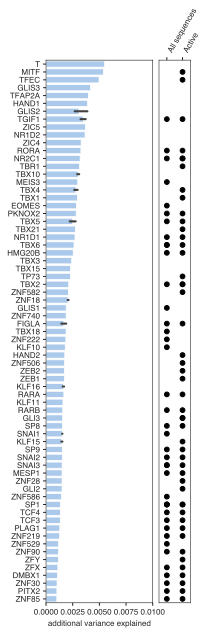

In [158]:
for tfs, xlims, pt in zip([all_tfs],
                          [(0, 0.01)],
                          ["1"]):
    sub = over_1p[over_1p["HGNC symbol"].isin(tfs)]
    
    fig = plt.figure(figsize=(8, 10))

    ax1 = plt.subplot2grid((1, 12), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((1, 12), (0, 3), colspan=1, sharey=ax1)

    yvals = []
    symbs = []
    c = 0
    for i, row in sub.iterrows():
        symb = row["HGNC symbol"]
        if symb not in symbs:
            yvals.append(c)
            symbs.append(symb)
            c += 1
        else:
            yvals.append(c)

    sub["yval"] = yvals
    print(len(sub))
    sns.barplot(y="HGNC symbol", x="rsq", data=sub, palette=full_pal, ax=ax1)
    ax1.set_ylabel("")
    ax1.set_xlabel("additional variance explained")
    ax1.set_xlim(xlims)

    mrg = sub.merge(biotype_melt, on="index", how="left")
    mrg = mrg[["yval", "HGNC symbol", "variable", "value"]]
    ax2.plot(mrg["value"], mrg["yval"], 'o', color="black")
    ax2.set_xlim((-0.5, 1.5))
    ax2.set_ylim((np.max(yvals)-0.5, -0.5))
    ax2.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
    ax2.xaxis.set_ticks([0,1])
    ax2.set_xticklabels(["All sequences","Active"], rotation=60, ha="left", va="bottom")
    
    plt.show()
    fig.savefig("FigS9_active_%s.svg" % ("VSMC"), dpi=300, bbox_inches="tight")
    plt.close()

## 7. write file

In [159]:
supp_file = all_motif_results[["HGNC symbol", "short_id", "rsq", "beta", "padj", "activ_or_repr"]]
supp_file = supp_file.sort_values(by="HGNC symbol")
supp_file.head()

,HGNC symbol,short_id,rsq,beta,padj,activ_or_repr
0,AC023509.3,M08490_1,5.330479e-07,-0.008692,1.0,repressing
2,AC138696.1,M09315_1,4.528509e-06,-0.015738,1.0,repressing
4,AHR,M03663_1,0.000000e+00,0.000000,1.0,None
5,AHRR,M03663_1,0.000000e+00,0.000000,1.0,None
6,AIRE,M06440_1,1.755243e-06,-0.008734,1.0,repressing


In [160]:
supp_file.columns = ["gene_name", "cisbp_motif_id", "var_explained", "beta", "padj", "activ_or_repr"]
supp_file.head()

,gene_name,cisbp_motif_id,var_explained,beta,padj,activ_or_repr
0,AC023509.3,M08490_1,5.330479e-07,-0.008692,1.0,repressing
2,AC138696.1,M09315_1,4.528509e-06,-0.015738,1.0,repressing
4,AHR,M03663_1,0.000000e+00,0.000000,1.0,None
5,AHRR,M03663_1,0.000000e+00,0.000000,1.0,None
6,AIRE,M06440_1,1.755243e-06,-0.008734,1.0,repressing


In [161]:
supp_file.to_csv("../../data/SuppTable_Motifs_VSMC.txt", sep="\t", index=False)

## make file for downstream analyses

In [162]:
all_motif_results = all_motif_results.merge(biotype_res[["index", 
                                                         "All Sequences_enr",'Active_enr']], on="index")
all_motif_results.head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
0,M08571_1,10.447888,1.227898e-03,0.001076,0.121404,0.022954,M08571_1,DMBX1,activating,0.0,1.0
1,M05671_1,27.807244,1.340234e-07,0.002862,0.279105,0.000009,M05671_1,EOMES,activating,NaN,NaN
2,M05705_1,18.331397,1.856226e-05,0.001887,0.189439,0.000641,M05705_1,FIGLA,activating,0.0,1.0
3,M08661_1,13.967159,1.860320e-04,0.001438,0.147983,0.004075,M08661_1,FIGLA,activating,0.0,1.0
4,M05763_1,14.604603,1.325903e-04,0.001504,0.156739,0.002998,M05763_1,GLI2,activating,NaN,1.0


In [163]:
all_motif_results.to_csv("../../data/sig_motifs_VSMC.txt", sep="\t", index=False)

## Enrichment of Repetitive elements 

In [24]:
activity = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/TF_Analysis/sig_motifs.txt', sep="\t")

In [25]:
activity.head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr
0,M08571_1,10.449153,1.227057e-03,0.001075,0.121389,0.022938,M08571_1,DMBX1,activating,0.0,1.0
1,M05671_1,28.597301,8.910628e-08,0.002940,0.283033,0.000006,M05671_1,EOMES,activating,NaN,1.0
2,M05705_1,18.852119,1.412541e-05,0.001939,0.192104,0.000490,M05705_1,FIGLA,activating,0.0,1.0
3,M08661_1,14.341141,1.524955e-04,0.001476,0.149835,0.003341,M08661_1,FIGLA,activating,0.0,1.0
4,M05763_1,14.944286,1.107329e-04,0.001538,0.158258,0.002504,M05763_1,GLI2,activating,NaN,1.0


In [27]:
### RepeatMasker ####
repeat_masker = pd.read_table('~/marenostrum/Projects/Breast/ANALYSIS/Hypertension/data/snps_repeat_masker.info.txt', sep=' ')
repeat_masker['query'] = repeat_masker['query'].str.replace("_1", "")
repeat_masker = repeat_masker.drop_duplicates()
repeat_masker.head()

,query,family,beginR
0,chr10:102604446:102604581,L1PB1,LINE/L1
2,chr10:102615697:102615832,MSTB,LTR/ERVL-MaLR
4,chr10:102617651:102617786,(TTG)n,Simple_repeat
5,chr10:102617651:102617786,AluSx,SINE/Alu
8,chr10:104598927:104599062,MER11A,LTR/ERVK


In [46]:
cols = ['chrom', 'actual_start', 'actual_end']
index_elem['query'] = index_elem[cols].apply(lambda row: ':'.join(row.values.astype(str)), axis=1)
index_elem.head()

,element,tile_type,name,unique_name,chrom,strand,actual_start,actual_end,dupe_info,sequence_name,query
0,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_BUT_HAS_SNP,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
25,ACTAATGGCTGGAAAATGTTTCTACTTCTAAAAATAGTGAAAGAAT...,WILDTYPE_SNP_INDIV,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844__rs12705390__7:106410...,chr7,+,106410709,106410844,1,chr7:106410709:106410844__rs12705390__7:106410...,chr7:106410709:106410844
50,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_BUT_HAS_SNP,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
75,TTAGCAACTTTACTAGTCTCATCAATGCAGGAATGGAGGTTACTTG...,WILDTYPE_SNP_INDIV,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925__rs17477177__7:106411...,chr7,+,106411790,106411925,2,chr7:106411790:106411925__rs17477177__7:106411...,chr7:106411790:106411925
100,AAAACTAAGATTACAGTTAAAAATTACACTGTGATATATATATATC...,WILDTYPE_BUT_HAS_SNP,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149__rs62481856__7:106412...,chr7,+,106412014,106412149,3,chr7:106412014:106412149__rs62481856__7:106412...,chr7:106412014:106412149


In [86]:
biotype_motif_res = {}

for i, row in activity.iterrows():
    motif_id = row["index"]
    print("(#%s: %s)" % (i+1, motif_id))
    
    human_motifs_sub = motifs_merged[(motifs_merged["# motif_id"] == motif_id)]["unique_name"].unique()
    
    tmp = {}
    for biotype in ["Repetitive"]:
        
        # group no CAGE + reclassified together here
        if biotype == "All Sequences":

            human_sub = index_elem[index_elem["tile_type"].isin(['WILDTYPE_BUT_HAS_SNP','WILDTYPE_SNP_INDIV'])]["unique_name"].unique()

            human_not_sub = index_elem[index_elem["tile_type"].isin(['RANDOM'])]["unique_name"].unique()
        else:
            human_sub = index_elem[index_elem["query"].isin(repeat_masker['query'])]["unique_name"].unique()
            
            human_not_sub = index_elem[~index_elem["query"].isin(repeat_masker['query'])]["unique_name"].unique()
    
        # count occurrences of biotypes w/ and w/o motifs
        n_human_biotype_w_motif = len([x for x in human_sub if x in human_motifs_sub])
        n_human_not_biotype_w_motif = len([x for x in human_not_sub if x in human_motifs_sub])

        n_human_biotype_wo_motif = len([x for x in human_sub if x not in human_motifs_sub])
        n_human_not_biotype_wo_motif = len([x for x in human_not_sub if x not in human_motifs_sub])

        # hypergeometric test - combined
        tot_biotype_w_motif = n_human_biotype_w_motif
        tot_biotype = n_human_biotype_w_motif + n_human_biotype_wo_motif
        tot_motif = tot_biotype_w_motif + n_human_not_biotype_w_motif
        tot = tot_biotype + n_human_not_biotype_w_motif + n_human_not_biotype_wo_motif

        both_pval = stats.hypergeom.sf(tot_biotype_w_motif-1, tot, tot_biotype, tot_motif)

        # note results

        s = biotype
        tmp["%s_pval" % s] = both_pval
        
    biotype_motif_res[motif_id] = tmp

(#1: M08571_1)
(#2: M05671_1)
(#3: M05705_1)
(#4: M08661_1)
(#5: M05763_1)
(#6: M08727_1)
(#7: M08729_1)
(#8: M05766_1)
(#9: M08731_1)
(#10: M08731_1)
(#11: M05767_1)
(#12: M06569_1)
(#13: M08749_1)
(#14: M02159_1)
(#15: M08863_1)
(#16: M08865_1)
(#17: M08876_1)
(#18: M08874_1)
(#19: M05868_1)
(#20: M08878_1)
(#21: M05897_1)
(#22: M05902_1)
(#23: M00255_1)
(#24: M08989_1)
(#25: M08991_1)
(#26: M09872_1)
(#27: M09070_1)
(#28: M09068_1)
(#29: M09072_1)
(#30: M05997_1)
(#31: M02715_1)
(#32: M10176_1)
(#33: M10181_1)
(#34: M09106_1)
(#35: M09106_1)
(#36: M06062_1)
(#37: M09141_1)
(#38: M09139_1)
(#39: M09145_1)
(#40: M09147_1)
(#41: M06128_1)
(#42: M06131_1)
(#43: M09185_1)
(#44: M09977_1)
(#45: M06148_1)
(#46: M06152_1)
(#47: M09197_1)
(#48: M02208_1)
(#49: M06156_1)
(#50: M09201_1)
(#51: M09205_1)
(#52: M06165_1)
(#53: M09209_1)
(#54: M06171_1)
(#55: M06172_1)
(#56: M06173_1)
(#57: M06174_1)
(#58: M09211_1)
(#59: M06175_1)
(#60: M06176_1)
(#61: M06186_1)
(#62: M06446_1)
(#63: M09241_1)
(

In [87]:
biotype_res = pd.DataFrame.from_dict(biotype_motif_res, orient="index").reset_index()
biotype_res.head()

,index,Repetitive_pval
0,M00255_1,4.049580e-06
1,M02159_1,6.156123e-01
2,M02208_1,1.213673e-03
3,M02702_1,5.482209e-08
4,M02715_1,8.947450e-07


In [88]:
biotype_res["padj"] = multicomp.multipletests(biotype_res["Repetitive_pval"], method="fdr_bh")[1]
len(biotype_res[biotype_res["padj"] < 0.05])

66

In [89]:
def is_sig(row):
    if row["padj"] < 0.05:
        return 1
    else:
        return 0

In [90]:
biotype_res["sig"] = biotype_res.apply(is_sig, axis=1)
biotype_res.head()

,index,Repetitive_pval,padj,sig
0,M00255_1,4.049580e-06,8.388416e-06,1
1,M02159_1,6.156123e-01,7.141103e-01,0
2,M02208_1,1.213673e-03,1.820510e-03,1
3,M02702_1,5.482209e-08,1.445310e-07,1
4,M02715_1,8.947450e-07,2.048495e-06,1


In [91]:
biotype_res['Repetitive_pval'] = biotype_res['padj']
biotype_res.head()

,index,Repetitive_pval,padj,sig
0,M00255_1,8.388416e-06,8.388416e-06,1
1,M02159_1,7.141103e-01,7.141103e-01,0
2,M02208_1,1.820510e-03,1.820510e-03,1
3,M02702_1,1.445310e-07,1.445310e-07,1
4,M02715_1,2.048495e-06,2.048495e-06,1


In [92]:
def mrna_vars(row):
    if row["Repetitive_pval"] < 0.05:
        return 0
    else:
        return np.nan
    
    
biotype_res["Repetitive_enr"] = biotype_res.apply(mrna_vars, axis=1)
biotype_res = biotype_res.reset_index()

In [93]:
biotype_melt = pd.melt(biotype_res, id_vars="index", value_vars=["Repetitive_enr"])
biotype_melt.head()

,index,variable,value
0,M00255_1,Repetitive_enr,0.0
1,M02159_1,Repetitive_enr,NaN
2,M02208_1,Repetitive_enr,0.0
3,M02702_1,Repetitive_enr,0.0
4,M02715_1,Repetitive_enr,0.0


In [94]:
all_motif_results = activity.merge(biotype_res[["index", 
                                                         "Repetitive_enr"]], on="index")
all_motif_results.head()

,index,lr_test,pval,rsq,beta,padj,short_id,HGNC symbol,activ_or_repr,All Sequences_enr,Active_enr,Repetitive_enr
0,M08571_1,10.449153,1.227057e-03,0.001075,0.121389,0.022938,M08571_1,DMBX1,activating,0.0,1.0,0.0
1,M05671_1,28.597301,8.910628e-08,0.002940,0.283033,0.000006,M05671_1,EOMES,activating,NaN,1.0,0.0
2,M05705_1,18.852119,1.412541e-05,0.001939,0.192104,0.000490,M05705_1,FIGLA,activating,0.0,1.0,0.0
3,M08661_1,14.341141,1.524955e-04,0.001476,0.149835,0.003341,M08661_1,FIGLA,activating,0.0,1.0,0.0
4,M05763_1,14.944286,1.107329e-04,0.001538,0.158258,0.002504,M05763_1,GLI2,activating,NaN,1.0,0.0


In [95]:
over_1p = all_motif_results[all_motif_results["rsq"] >= 0.001].sort_values(by="rsq", ascending=False)
len(over_1p)

83

In [96]:
all_tfs = over_1p["HGNC symbol"].unique()
print(len(all_tfs))
all_tfs[0:5]

72


array(['T', 'MITF', 'TFEC', 'GLIS3', 'TFAP2A'], dtype=object)

In [98]:
pal = {"repressing": sns.color_palette("pastel")[3], "activating": sns.color_palette("pastel")[0]}

In [99]:
full_pal = {}
for i, row in over_1p.iterrows():
    full_pal[row["HGNC symbol"]] = pal[row["activ_or_repr"]]

83


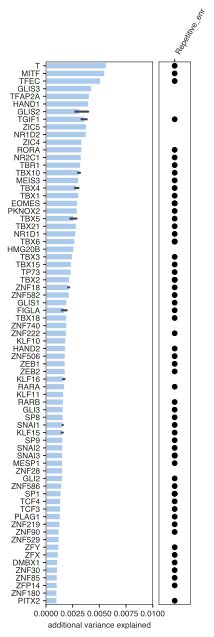

In [100]:
for tfs, xlims, pt in zip([all_tfs],
                          [(0, 0.01)],
                          ["1"]):
    sub = over_1p[over_1p["HGNC symbol"].isin(tfs)]
    
    fig = plt.figure(figsize=(8, 10))

    ax1 = plt.subplot2grid((1, 12), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((1, 12), (0, 3), colspan=1, sharey=ax1)

    yvals = []
    symbs = []
    c = 0
    for i, row in sub.iterrows():
        symb = row["HGNC symbol"]
        if symb not in symbs:
            yvals.append(c)
            symbs.append(symb)
            c += 1
        else:
            yvals.append(c)

    sub["yval"] = yvals
    print(len(sub))
    sns.barplot(y="HGNC symbol", x="rsq", data=sub, palette=full_pal, ax=ax1)
    ax1.set_ylabel("")
    ax1.set_xlabel("additional variance explained")
    ax1.set_xlim(xlims)

    mrg = sub.merge(biotype_melt, on="index", how="left")
    mrg = mrg[["yval", "HGNC symbol", "variable", "value"]]
    ax2.plot(mrg["value"], mrg["yval"], 'o', color="black")
    ax2.set_xlim((-0.5, 0.5))
    ax2.set_ylim((np.max(yvals)-0.5, -0.5))
    ax2.tick_params(labelleft=False, labelbottom=False, bottom=False, left=False, top=True, labeltop=True)
    ax2.xaxis.set_ticks([0])
    ax2.set_xticklabels(["Repetitive_enr"], rotation=60, ha="left", va="bottom")
    
    plt.show()
    fig.savefig("FigS9_repetitive_%s.svg" % ("CM"), dpi=300, bbox_inches="tight")
    plt.close()